# 2.155/6 Challenge Problem 2
<font size="1">
  Demo created by L. Regenwetter in Oct. 2023;   Artwork by Jessica Shung. </font>

In [1]:
from utils_public import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor

c:\Users\layal\anaconda3\envs\cp2env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# !pip install scikit-learn
# !conda install matplotlib
# !pip install autogluon && pip install autogluon.tabular[tabpfn,vowpalwabbit,imodels,skex,skl2onnx]
# !pip uninstall scipy

# Overview
In this challenge problem, you've been hired as an urban planner for an urban development project in budding city. The city is rapidly expanding and has a large area that they are looking to zone. The mayor has asked you to consult with several of their advisors to figure out an optimal zoning strategy. These advisors are an interesting bunch. Though they mean well, but they are somewhat biased towards their own areas of expertise. Pleasing all of them will be tricky!

## Let's meet the advisors:
**The Wellness Advisor:** With a background in the parks & rec department of the city government, the wellness advisor is focused on the health and wellbeing (both physical and mental) of citizens. Among other things, they are very invested in the quality and accessibility of city's green spaces.

**The Tax Advisor:** With a background in the revenue department of the city government, the tax advisor is focused on balancing city expenditures with income and keeping the city's economy afloat. Among other things, they are invested in maximizing property value and reducing city expenditures.  

**The Transportation Advisor**: As a former executive in the local public transportation authority, the transportation advisor places an emphasis on accessibility and emissions. Among other objectives, they are focused on mimizing the distance over which the workforce needs to commute.

**The Business advisor:** As a professor emeritus of economics at the state college in the city, the economic advisor is fixated on the general economic prosperity of the city's businesses and inhabitants. Among other things, they prioritize the overall economic output of the city.

## Understanding City Zoning:
Cities are often comprised of districts. Typically, the city government zones areas allowing them some amount of control over what goes on in each distict. To simplify, we will be represing city districts as discrete spaces in a 7x7 grid. Each grid space will be filled with exactly one of five types of zones. We will discuss the districts below:

**Residential Zones [0]:** Residential zones are comprised primarily of housing and are where the workforce lives

**Industrial Zones [1]:** Industrial zones are the manufacturing centers of the city, packed with factories producing food and goods.

**Commercial Zones [2]:** Commercial zones are the retail hubs of the city, consisting of markets, stores, and restaurants.

**Park Zones [3]:** City parks are the green spaces of the city -- small tastes of nature within an urban environment.

**Office Zones [4]:** Office zones are the enterprise centers of global corporations and local businesses alike.

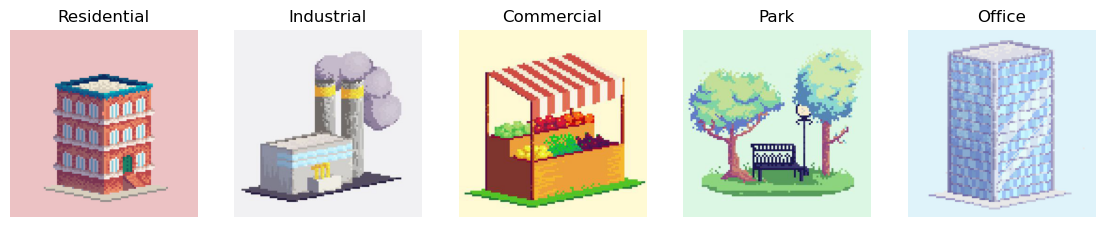

In [3]:
plot_districts()

## The Data
The mayor has provided you access to a large dataset of 500,000 possible zoning configurations. Additionally, the mayor asked the advisors to score some of these zoning configurations according to their subjective opinions of efficacy. Since the advisors are "only human" they have only been able to label ~5,000 configurations each. Some of their assessments may seem questionable to you, but they mayor insists that the advisors are "experts" and their ratings should not be questioned.

Let's take a look at the data. First, lets have a look at the zoning layouts you are given.

In [4]:
grids = load_grids() #Helper function we have provided to load the grids from the dataset
grids.shape #Check shape

(500000, 7, 7)

Let's examine the first grid in the dataset. It consists of 7x7 entries, each ranging from 0 to 4. The entries denote the district occupying the grid space (labeled above).

In [5]:
grids[0]

array([[4., 3., 0., 2., 3., 4., 4.],
       [0., 2., 0., 4., 3., 0., 3.],
       [4., 1., 0., 0., 1., 0., 3.],
       [2., 1., 2., 1., 3., 1., 1.],
       [2., 2., 2., 2., 4., 2., 3.],
       [2., 0., 0., 2., 0., 1., 0.],
       [4., 2., 4., 1., 3., 2., 4.]])

Let's visualize some of these grids. We have provided some utilities, mainly fucused on visualization, which we imported at the top of the notebook.

<Figure size 640x480 with 0 Axes>

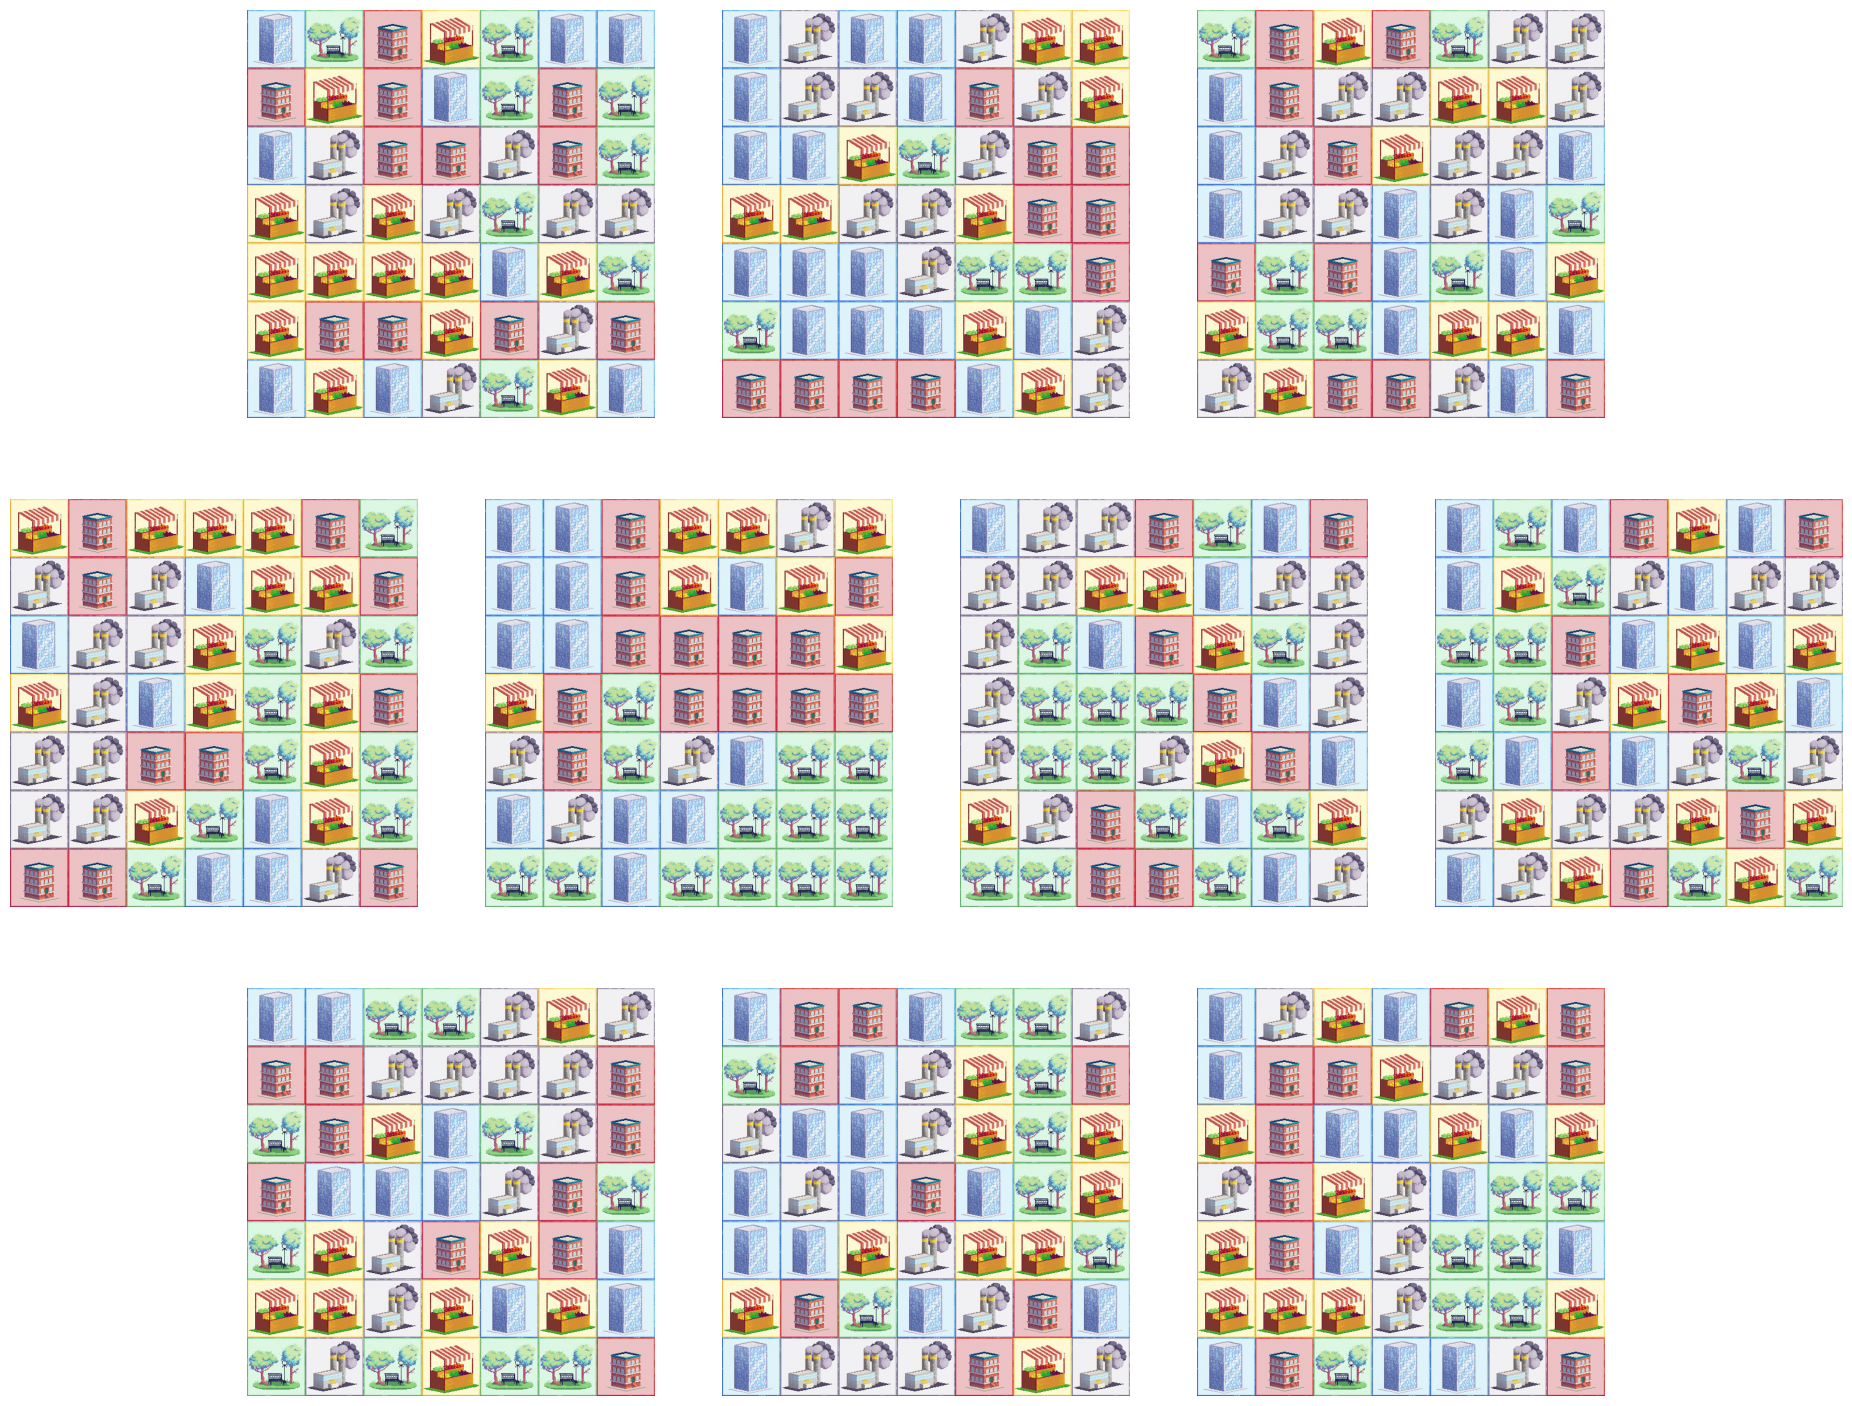

In [6]:
plot_n_grids(grids[:10]) #Plotting function that plots some number of grids in a clean layout

Now lets have a look at the advisor scores:

In [7]:
ratings = np.load("datasets/scores.npy") #Load advisor scores
score_order = ["Wellness", "Tax", "Transportation", "Business"] #This is the order of the scores in the dataset
ratings_df = pd.DataFrame(ratings, columns = score_order) #Create a dataframe
display(ratings_df) #Print dataframe

Wellness  Tax  Transportation  Business
0            NaN  NaN             NaN       NaN
1            NaN  NaN             NaN       NaN
2            NaN  NaN             NaN       NaN
3            NaN  NaN             NaN       NaN
4            NaN  NaN             NaN       NaN
...          ...  ...             ...       ...
499995       NaN  NaN             NaN       NaN
499996       NaN  NaN             NaN       NaN
499997       NaN  NaN             NaN       NaN
499998       NaN  NaN             NaN       NaN
499999       NaN  NaN             NaN       NaN

[500000 rows x 4 columns]

We can see that the vast majority of ratings are NaN. After all, only 1% of the data is labeled. Let's confirm that there are the right number of NaNs in each column:

In [8]:
ratings_df.isna().sum()

Wellness          495001
Tax               495002
Transportation    495001
Business          495000
dtype: int64

Let's plot the distribution over the scores that are rated. We see that each advisor's scores are fairly uniform from 0 to 1.

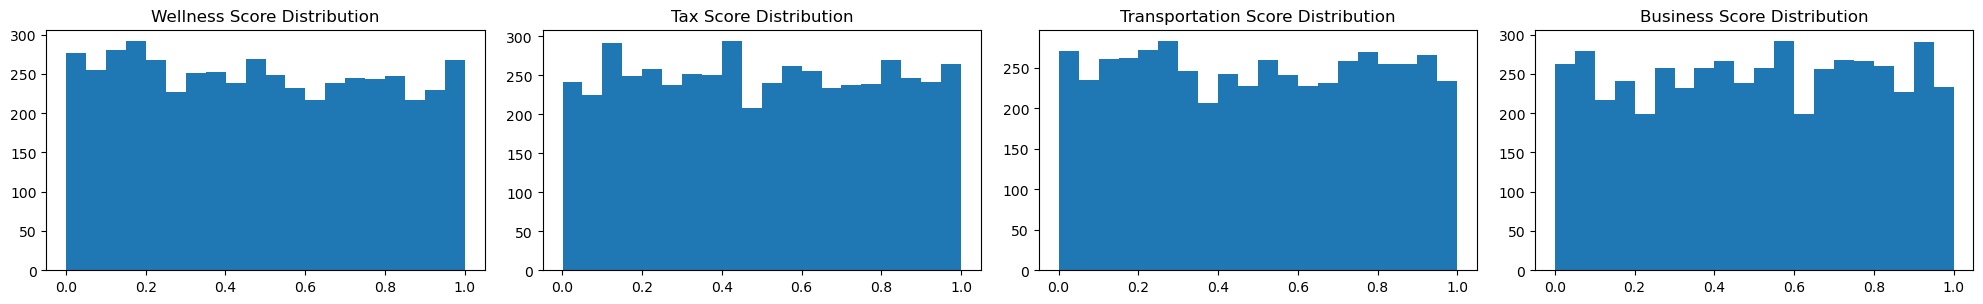

In [9]:
plot_ratings_histogram(ratings)

## The Task:
**Satisfying the Advisors:**
You are tasked with finding zoning layouts that "satisfy" all four advisors, meaning that they each assign a score of at least 0.85. If even one of the advisors rates a layout under a 0.85, it will be rejected as a candidate. You much identify designs from the dataset or generate new designs that *you believe* will be accepted by the advisors.

**Identifying a diverse set:** The mayor has asked for a variety of "diverse" design candidates -- 100 city layouts to be exact -- which they will show to the advisors. The overall diversity of all valid (non-rejected) designs will be calculated. With this diversity metric, more designs is always better, so it is in your best interest to ensure that as few of your submitted designs are rejected as possible.

We have provided the function we will use to evaluate diversity. Here are a few tests to build some intuition with the diversity score.

### Building Intuition for Diversity

In [10]:
diversity_score(grids[:100]) #Diversity of the first 100 grids in the dataset

0.7989527932385075

In [11]:
#If we set the top left corner to 0 in all grids, the diversity score should go down
g_1 = grids.copy()
g_1[:,0,0] = 0
diversity_score(g_1[:100])

0.78281179138322

In [12]:
#If some grids are the same, the diversity score should go down
g_2 = grids.copy()
g_2[0] = g_2[1]
diversity_score(g_2[:100])

0.798726035868893

In [13]:
#If we submit fewer grids, the diversity score should go down (as will occur if invalid designs are submitted)
diversity_score(g_2[:99]) #Diversity of the first 99 grids in the dataset

0.7826509997938569

<Figure size 640x480 with 0 Axes>

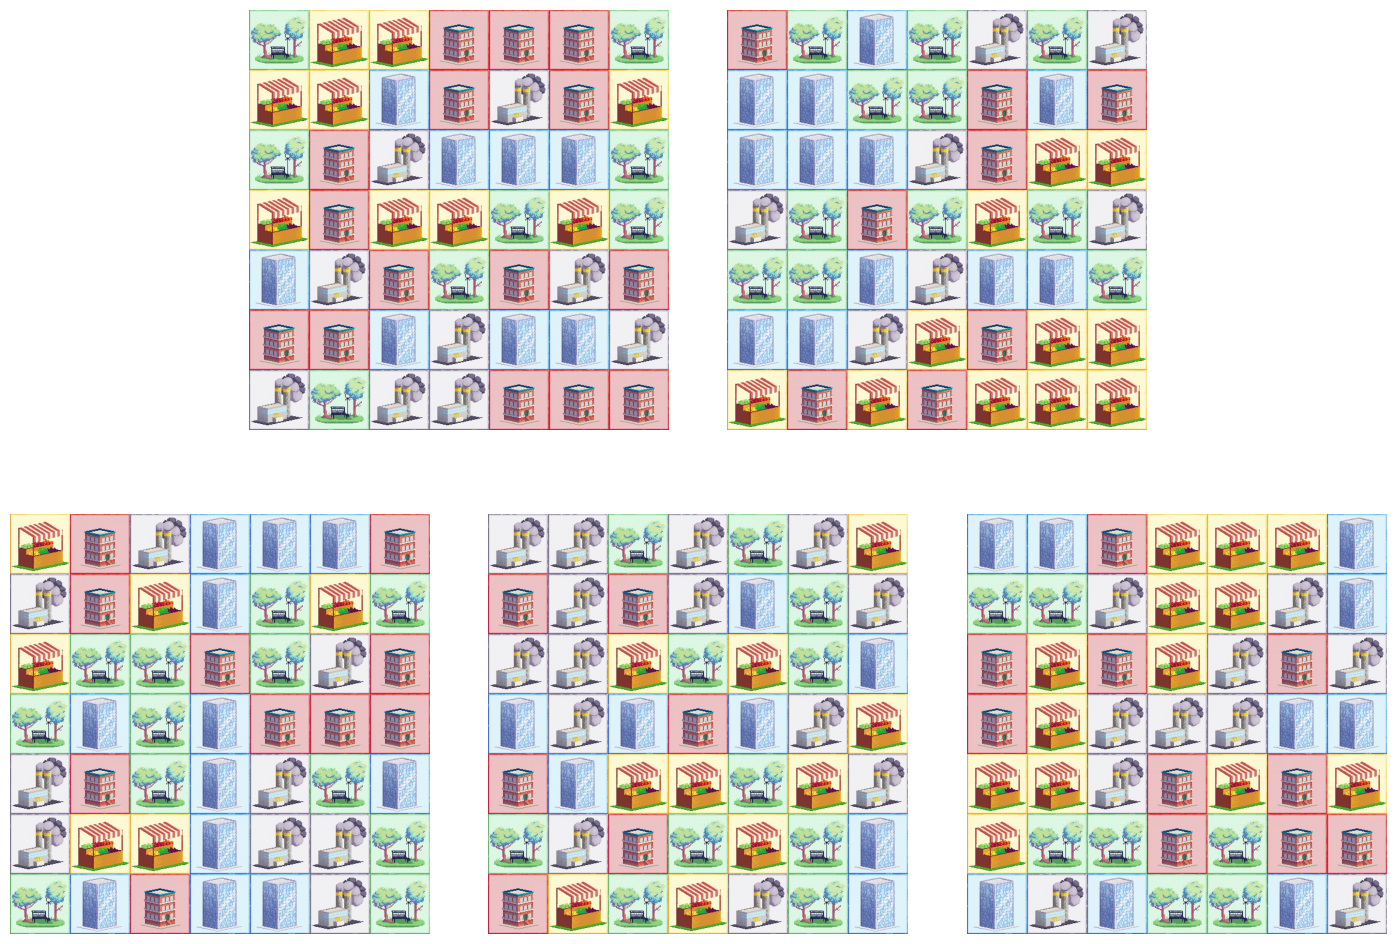

Diversity Score: 1.0


In [14]:
# A diverse set of five grids where no two cities have the same type of district in the same grid space
diverse_set = np.random.rand(5,7,7).argsort(0)
plot_n_grids(diverse_set)
print(f"Diversity Score: {diversity_score(diverse_set, 5)}")


<Figure size 640x480 with 0 Axes>

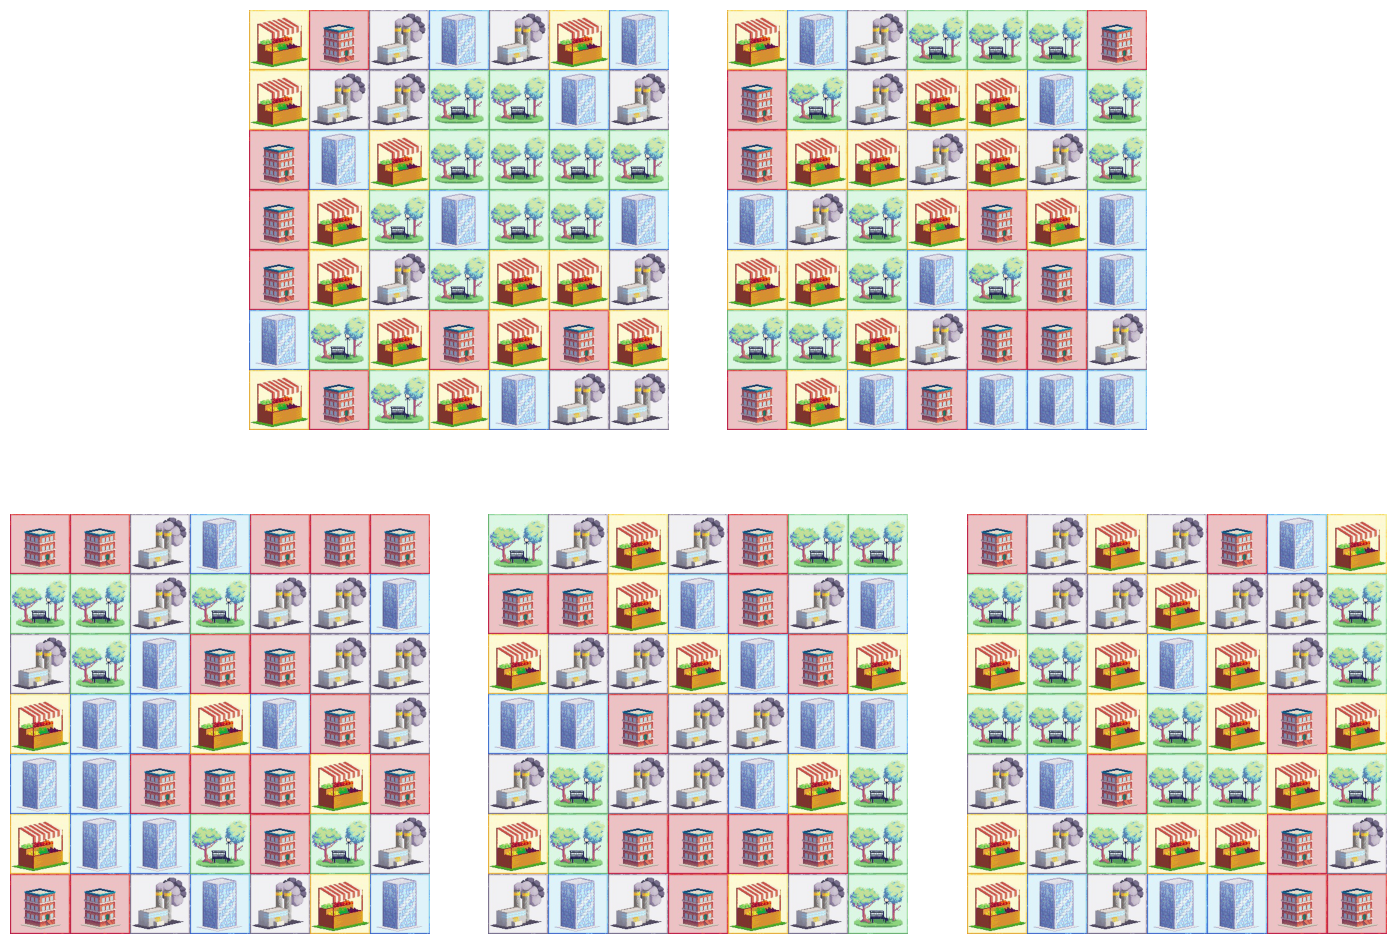

Diversity Score: 0.7877551020408163


In [15]:
#set of 5 grids where each district is independent and random with 20% probability for each district
random_set = np.random.randint(0,5, size=(5,7,7))
plot_n_grids(random_set)
print(f"Diversity Score: {diversity_score(random_set, 5)}")

<Figure size 640x480 with 0 Axes>

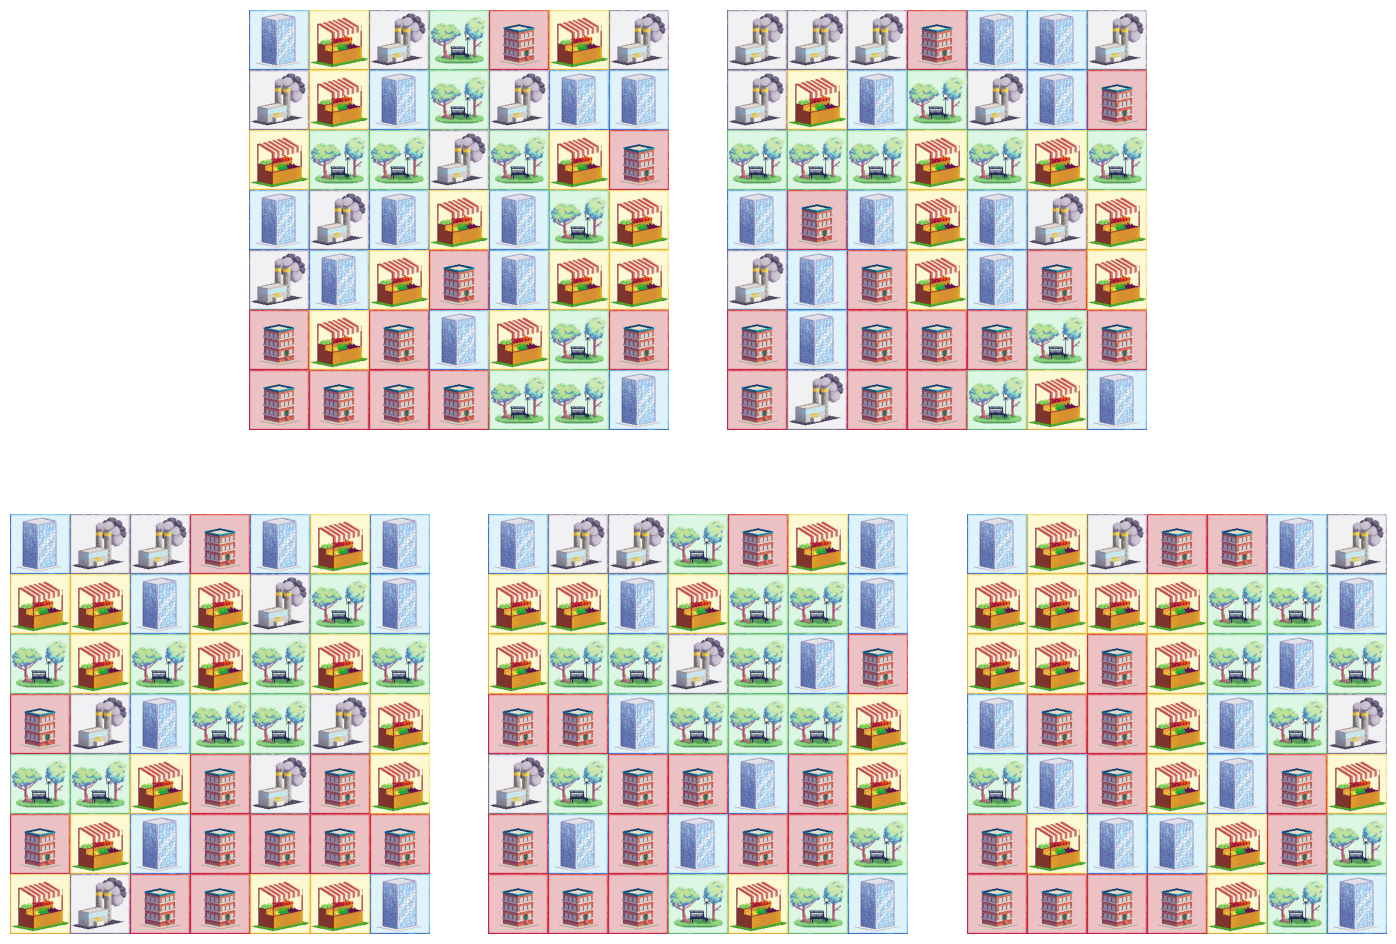

Diversity Score: 0.47346938775510206


In [16]:
#Set of five grids where each grid space only takes one of two types across all cities
r1 = np.random.randint(0,5,size=(7,7))
r2 = np.random.randint(0,5,size=(7,7))
mask = np.random.randint(0,2,size=(5,7,7))
non_diverse_set = r1 * mask + r2 * (1-mask)
plot_n_grids(non_diverse_set)
print(f"Diversity Score: {diversity_score(non_diverse_set, 5)}")

Assuming that all designs in your submitted sets are valid, you will be able to *exactly calculate* the diversity of your submitted sets.

# Your Code

Time to get coding! We recommend you start by training some regressors to predict the advisor scores. From there, it's up to you to generate or select city designs that you think will satisfy the requirements!



### Hints:
1. The advisors pay a lot of attention to the **adjacency** of districts as well as the **distances** from certain types of districts to others.
2. This is a grid-structured city. What **distance metric** is appropriate?
3. Though adding **novel** varied designs to your final set will increase the diversity score most, **duplicates** of valid designs will still slightly increase the diversity score, whereas invalid designs will not (see utils function for exact calculation).



We provided a small helper function that grabs the labeled subset of the dataset for some advisor:

In [17]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

### Other Fxns

### Changing Predictor (Autogluon Try #1)

### Neural Net (Pytorch)

In [114]:
#imports
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from transformers import AutoConfig
from torch.utils.data import DataLoader, TensorDataset
import sklearn
grids=load_grids()
ratings=np.load("datasets/scores.npy")
from sklearn.metrics import r2_score

import numpy as np
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [115]:

def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, i):
    plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=3, c = "#F08E18") #Train set in orange
    plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=5, c = "#DC267F") #Test set in magenta
    plt.plot([0,1], [0,1], label="target", linewidth=3, c="k") # Target line in Black
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"Advisor {i} Predictions")
    plt.legend()
    plt.show()
    print(f"Train Set R2 score: {r2_score(ratings_train, preds_train)}") #Calculate R2 score
    print(f"Test Set R2 score: {r2_score(ratings_test, preds_test)}")


In [169]:
 grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_subset, ratings_subset,
                                                                    stratify=ratings_subset, 
                                                                     test_size=0.25)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [116]:
def get_advisor_data(grids, ratings, num, batch_size):
    grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,num]) #gets subset of the dataset rated by advisor i
    grids_subset = grids_subset.reshape(grids_subset.shape[0], 49)
    grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_subset, ratings_subset)
    grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_subset, ratings_subset,
                                                                    stratify=ratings_subset, 
                                                                     test_size=0.25)
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(grids_train, dtype=torch.float)
    y_train_tensor = torch.tensor(ratings_train, dtype=torch.float)

    # Create a TensorDataset from the tensors
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    # Create a DataLoader from the TensorDataset
    trainloader = DataLoader(train_dataset, batch_size, shuffle=True)

    # Convert numpy arrays to PyTorch tensors
    X_test_tensor = torch.tensor(grids_test, dtype=torch.float)
    y_test_tensor = torch.tensor(ratings_test, dtype=torch.float)

    # Create a TensorDataset from the tensors
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create a DataLoader from the TensorDataset
    testloader = DataLoader(test_dataset, batch_size, shuffle=True)
    
    return X_train_tensor, X_test_tensor, ratings_train, ratings_test, trainloader, testloader

In [117]:
# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(49, 25)  # 49 input features, 25 output features
        self.fc2 = nn.Linear(25, 1)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.fc3(x)
        x = self.activation(x)
        return x


In [142]:
def nn_torch_old(model, grids, ratings, adv):
    # Create the network, loss function and optimizer
    model.train() # Set the network to training mode
    criterion = nn.MSELoss()  # For regression tasks
    optimizer = optim.AdamW(model.parameters(), lr=.1)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, 
                                                     min_lr=1e-8,
                                                     verbose=True) # Reduce learning rate when a metric has stopped improving
    # Train the network
    for epoch in range(100):  # Loop over the dataset multiple times
        running_loss = 0.0 # Keep track of the loss
        # print(running_loss)
        for i, data in enumerate(trainloader):  # Replace trainloader with your actual data loader
            inputs, labels = data # Get the inputs from the data loader
            optimizer.zero_grad() 
            outputs = model(inputs)
            labels = labels.reshape(-1,1)
            # loss = criterion(outputs.view(-1), labels.view(-1))
            loss = criterion(outputs, labels)
            loss.backward()
            scheduler.step(loss)
            running_loss += loss.item()
        if epoch %10 == 0:
            print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')
    return model



In [123]:
def eval_model(model):
    model.eval()
    preds_test = np.array(model(X_test_tensor).detach().numpy())
    preds_train = np.array(model(X_train_tensor).detach().numpy())

    print('Finished Training')
    return preds_train, preds_test #predictions for the test set

In [129]:
grids.shape

(500000, 7, 7)

In [133]:
print(preds_test.shape)
print(ratings_test.shape)

(1250, 1)
(1250,)


In [137]:
def new_plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, i):
    plt.scatter(ratings_train.reshape(-1,1), preds_train.reshape(-1,1), label='Train Set Preds', s=3, c = "#F08E18") #Train set in orange
    plt.scatter(ratings_test.reshape(-1,1), preds_test.reshape(-1,1), label='Test Set Preds', s=5, c = "#DC267F") #Test set in magenta
    plt.plot([0,1], [0,1], label="target", linewidth=3, c="k") # Target line in Black
    plt.xlabel("Actual Rating")
    plt.ylabel("Predicted Rating")
    plt.title(f"Advisor {i} Predictions")
    plt.legend()
    plt.show()
    print(f"Train Set R2 score: {r2_score(ratings_train.reshape(-1,1), preds_train.reshape(-1,1))}") #Calculate R2 score
    print(f"Test Set R2 score: {r2_score(ratings_test.reshape(-1,1), preds_test.reshape(-1,1))}")


Epoch 00022: reducing learning rate of group 0 to 1.0000e-02.
Epoch 1, loss: 0.1088659957443413
Epoch 00043: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00064: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00085: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00106: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00127: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00148: reducing learning rate of group 0 to 1.0000e-08.
Epoch 11, loss: 0.1091784960345218
Epoch 21, loss: 0.10887217619701435
Epoch 31, loss: 0.10957607705342143
Epoch 41, loss: 0.10893104578319349
Epoch 51, loss: 0.10905007978803233
Epoch 61, loss: 0.10884863353873554
Epoch 71, loss: 0.10900589098271571
Epoch 81, loss: 0.10921946971824295
Epoch 91, loss: 0.10872094137103934
Epoch 100, loss: 0.10892942587011739
Finished Training


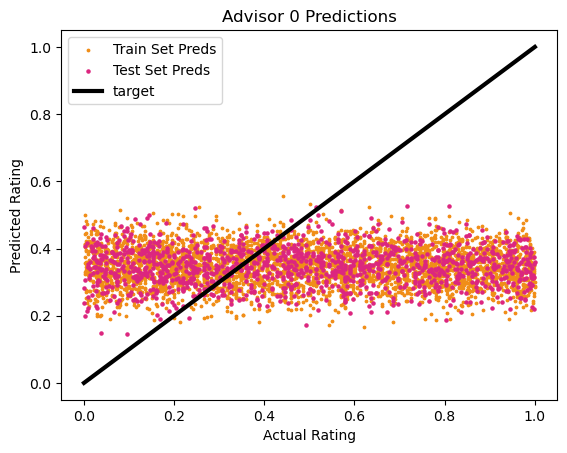

Train Set R2 score: -0.2866252667664635
Test Set R2 score: -0.24548726873208104


In [143]:
net = Net() # Create the network
all_predictions = []
all_predictors = []
batchsize=100
for adv in range(1):
    X_train_tensor, X_test_tensor, ratings_train, ratings_test, trainloader, testloader = get_advisor_data(grids, ratings, adv, batchsize)
    model = nn_torch_old(net, grids, ratings, adv)
    preds_train, preds_test = eval_model(model)
    new_plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, adv)
    all_predictions.append(preds_test)
    all_predictors.append(model)

Epoch 00018: reducing learning rate of group 0 to 1.0000e-02.
Epoch 00042: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00053: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00069: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00080: reducing learning rate of group 0 to 1.0000e-06.
Epoch 00091: reducing learning rate of group 0 to 1.0000e-07.
Epoch 00102: reducing learning rate of group 0 to 1.0000e-08.
Epoch 100, loss: 0.08622302673757076


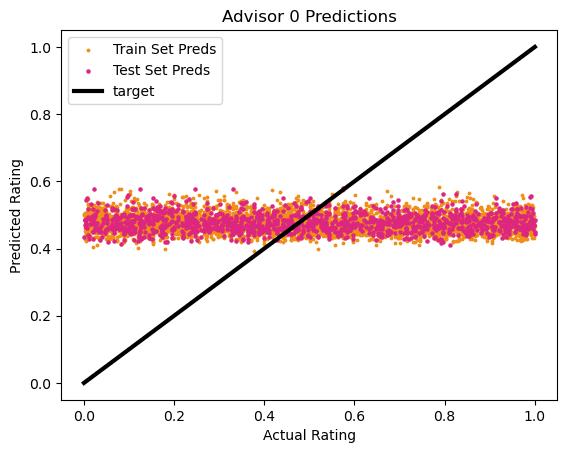

Train Set R2 score: -0.015175751079462563
Test Set R2 score: -0.012699295119473542
Finished Training


In [48]:
# all_predictions = []
# all_predictors = []
# for adv in range(1):
#     predstest, predstrain, predictor = nn_torch_old(grids, ratings, adv)
#     all_predictions.append(predstest)
#     all_predictors.append(predictor)

### Unchanged NN Code (No Grid Train)

In [ ]:
def nn_torch_un(grids, ratings, adv):
    grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,adv]) #gets subset of the dataset rated by advisor 0
    grids_subset = grids_subset.reshape(grids_subset.shape[0], 49)

    grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_subset, ratings_subset)
    # grids_train = pd.DataFrame(grids_train, columns = range(grids_subset.shape[1]), dtype = "object") #specify dtype of object to ensure categorical handling of data
    # grids_test = pd.DataFrame(grids_test, columns = range(grids_subset.shape[1]), dtype = "object")
    # preds_train = pd.DataFrame(ratings_train, columns = ["ratings"])
    # all_train = pd.concat([grids_train, preds_train], axis=1)
    
    # Convert DataFrame to numpy array
    # numpy_array = all_train.values

    # Split into features and labels
    X_train = grids_train  # all columns except the last one
    y_train = ratings_train  # the last column

    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float)

    # Create a TensorDataset from the tensors
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    # Create a DataLoader from the TensorDataset
    trainloader = DataLoader(train_dataset, batch_size=1000, shuffle=True)

    # Define the network architecture
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(49, 25)  # Replace 16 with the number of input features
            self.fc2 = nn.Linear(25, 1)  # Replace 1 with the number of output features
            self.activation = nn.Sigmoid()
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            x = self.activation(x)
            return x

    # Create the network, loss function and optimizer
    net = Net()
    net.train()
    criterion = nn.MSELoss()  # For regression tasks
    # optimizer = optim.SGD(net.parameters(), lr=0.001)
    optimizer = optim.Adam(net.parameters(), lr=1e-3)
    # Train the network
    for epoch in range(10):  # Loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):  # Replace trainloader with your actual data loader
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            # print(outputs)
            loss = criterion(outputs.view(-1), labels.view(-1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')
    # preds_train=[]
    # preds_train.extend(outputs.detach().numpy())
    # preds_train = np.array(preds_train)
    preds_train = np.array(outputs.detach().numpy())
    # Assuming grids_test and ratings_test are your test data
    X_test = grids_test
    y_test = ratings_test

    # Convert numpy arrays to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float)

    # Create a TensorDataset from the tensors
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create a DataLoader from the TensorDataset
    testloader = DataLoader(test_dataset, batch_size=1000)

    # Run the network on the test data and store the predictions
    preds_test = []
    net.eval()
    for data in testloader:
        inputs, labels = data
        outputs = net(inputs)
        preds_test.extend(outputs.detach().numpy())

    # Convert list to numpy array
    preds_test = np.array(preds_test)

    # Run the network on the train data and store the predictions
    preds_train = []
    for data in trainloader:
        inputs, labels = data
        outputs = net(inputs)
        preds_train.extend(outputs.detach().numpy())

    # Convert list to numpy array
    preds_train = np.array(preds_train)

    plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, adv)
        
    print('Finished Training')
    return preds_test, net #predictions for the test set

### CNN Attempt

## Grid Search (Final All Code)

#### Imports and Fxns

In [ ]:
from utils_public import *
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
import torch
import torch.nn as nn
import torch.optim as optim
import transformers
from transformers import AutoConfig
from torch.utils.data import DataLoader, TensorDataset
grids = load_grids()
ratings = np.load("datasets/scores.npy") #Load advisor scores

c:\Users\layal\anaconda3\envs\cp2env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
# from sklearn.metrics import r2_score

# def plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, i):
#     plt.scatter(ratings_train, preds_train, label='Train Set Preds', s=3, c = "#F08E18") #Train set in orange
#     plt.scatter(ratings_test, preds_test, label='Test Set Preds', s=5, c = "#DC267F") #Test set in magenta
#     plt.plot([0,1], [0,1], label="target", linewidth=3, c="k") # Target line in Black
#     plt.xlabel("Actual Rating")
#     plt.ylabel("Predicted Rating")
#     plt.title(f"Advisor {i} Predictions")
#     plt.legend()
#     plt.show()
#     print(f"Train Set R2 score: {r2_score(ratings_train, preds_train)}") #Calculate R2 score
#     print(f"Test Set R2 score: {r2_score(ratings_test, preds_test)}")

#### Finding Optimal Hyperparamaters for Each Advisor Neural Net

In [ ]:
advisor_params = []
# Define the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(49, 25)  # 49 input features, 25 output features
        self.fc2 = nn.Linear(25, 13)  #25 in, 13 out
        self.fc3 = nn.Linear(13, 1)   #13 in, 1 out
        self.activation = nn.Sigmoid() #sigmoid activation function
    def forward(self, x): #forward pass
        x = torch.relu(self.fc1(x)) #relu activation function
        x = torch.relu(self.fc2(x)) #relu activation function
        x = self.fc3(x) #no activation function on the last layer
        x = self.activation(x)
        return x
    
#define hyperparameter grid
param_grid={
    'batch_size': [10, 50, 100, 500, 1000, 1500],
    'max_epochs': [100, 200, 300],
    } 

# Create the network, loss function and optimizer
net = Net() # Create the network
criterion = nn.MSELoss()  # For regression tasks 
optimizer = optim.AdamW(net.parameters(), lr=0.1) #AdamW optimizer
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, 
                                                min_lr=1e-10,
                                                verbose=True) # Reduce learning rate when a metric has stopped improving

# create model with skorch
model = NeuralNetRegressor(
    Net,
    criterion=nn.MSELoss(),
    optimizer=optim.Adam,
    verbose=False,
    train_split=None
) 

for i in range(4):
    grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,i]) #gets subset of the dataset rated by advisor i
    grids_subset = grids_subset.reshape(grids_subset.shape[0], 49)
    
    # Convert numpy arrays to PyTorch tensors
    X_tensor = torch.tensor(grids_subset, dtype=torch.float32)
    y_tensor = torch.tensor(ratings_subset, dtype=torch.float32).reshape(-1,1)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_squared_error')
    advisor_params.append(grid.fit(X_tensor, y_tensor))

In [ ]:
# summarize results
for i in range(4):
    print("Best: %f using %s" % (advisor_params[i].best_score_, advisor_params[i].best_params_))
    # means = advisor_params[i].cv_results_['mean_test_score']
    # stds = advisor_params[i].cv_results_['std_test_score']
    # params = advisor_params[i].cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print("%f (%f) with: %r" % (mean, stdev, param))

#### Advisor Model Training and Validation

In [ ]:
grids=load_grids()
ratings=np.load("datasets/scores.npy")
#first entry batch size, second entry max epochs
params={0: [50, 200], 
        1: [50, 100], 
        2: [10, 300], 
        3: [10, 300]}

In [ ]:
def get_advisor_data(grids, ratings, num, batch_size):
    grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,num]) #gets subset of the dataset rated by advisor i
    grids_subset = grids_subset.reshape(grids_subset.shape[0], 49)
    grids_train, grids_test, ratings_train, ratings_test = train_test_split(grids_subset, ratings_subset)
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(grids_train, dtype=torch.float)
    y_train_tensor = torch.tensor(ratings_train, dtype=torch.float)

    # Create a TensorDataset from the tensors
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    # Create a DataLoader from the TensorDataset
    trainloader = DataLoader(train_dataset, batch_size, shuffle=True)

    # Convert numpy arrays to PyTorch tensors
    X_test_tensor = torch.tensor(grids_test, dtype=torch.float)
    y_test_tensor = torch.tensor(ratings_test, dtype=torch.float)

    # Create a TensorDataset from the tensors
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create a DataLoader from the TensorDataset
    testloader = DataLoader(test_dataset, batch_size, shuffle=True)
    
    return X_train_tensor, X_test_tensor, ratings_train, ratings_test, trainloader, testloader

In [ ]:
def nn_torch(X_train, X_test, ratings_train, ratings_test, trainloader, testloader, adv, max_epochs):
    # Define the network architecture
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(49, 25)  # 49 input features, 25 output features
            self.fc2 = nn.Linear(25, 13)  #25 in, 13 out
            self.fc3 = nn.Linear(13, 1)   #13 in, 1 out
            self.activation = nn.Sigmoid() #sigmoid activation function
        def forward(self, x): #forward pass
            x = torch.relu(self.fc1(x)) #relu activation function
            x = torch.relu(self.fc2(x)) #relu activation function
            x = self.fc3(x) #no activation function on the last layer
            x = self.activation(x)
            return x
        
    # Create the network, loss function and optimizer
    net = Net() # Create the network   
    criterion = nn.MSELoss()  # For regression tasks 
    optimizer = optim.AdamW(net.parameters(), lr=0.1) #AdamW optimizer
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, 
                                                min_lr=1e-10,
                                                verbose=True) # Reduce learning rate when a metric has stopped improving

    # Train the network
    net.train() # Set the network to training mode
    for epoch in range(max_epochs):  # Loop over the dataset multiple times
        running_loss = 0.0 # Keep track of the loss
        for i, data in enumerate(trainloader, 0):  
            inputs, labels = data # Get the inputs from the data loader
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            scheduler.step(loss)
            running_loss += loss.item()
    print(f'Epoch {epoch + 1}, loss: {running_loss / len(trainloader)}')

    # Run the network on the test data and store the predictions
    net.eval()
    preds_train = np.array(net(X_train).detach().numpy())
    preds_test = np.array(net(X_test).detach().numpy())

    plot_and_r2(preds_train, preds_test, ratings_train, ratings_test, adv)
        
    print('Finished Training')
    return preds_test, net #predictions for the test set

In [ ]:
#run code for all advisors
all_predictions = []
all_predictors = []
for adv in range(4):
    batch_size = params[adv][0]
    max_epochs = params[adv][1]
    X_train, X_test, ratings_train, ratings_test, trainloader, testloader = get_advisor_data(grids, ratings, adv, batch_size)
    predictions, predictor = nn_torch(X_train, X_test, ratings_train, ratings_test, trainloader, testloader, adv, max_epochs)
    all_predictions.append(predictions)
    all_predictors.append(predictor)

### Preparing a submission
Let's prepare a submission. We expect the final submission to be a 100x7x7 numpy array of integers between 0 and 4, inclusive. Note: we do NOT need your predicted scores. We will ask the advisors to score your submissions directly!
You can verify that your submission is formatted properly with the following asserts:

In [ ]:
#determine what the 100 grid scores resulted in
final_prediction_array = np.stack(all_predictions).T[0]
min_predictions = np.min(final_prediction_array, axis=1)
print(f"Number of valid grids (as predicted): {np.sum(min_predictions>0.85)}")
print(f"best predicted scores: {final_prediction_array[np.argmax(min_predictions)]}")
top_100_indices = np.argpartition(min_predictions, -100)[-100:] #indices of top 100 designs (as sorted by minimum advisor score)

In [ ]:
final_submission = grids[top_100_indices].astype(int)

In [ ]:
diversity_score(final_submission)

In [ ]:
assert final_submission.shape == (100, 7, 7)
assert final_submission.dtype == int
assert np.all(np.greater_equal(final_submission, 0) & np.less_equal(final_submission, 4))

We need each submission to have a unique submission ID for scoring. Generate a random ID and save the file using that ID:

In [ ]:
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", final_submission)

In [150]:
grids_subset

array([[[0., 4., 0., ..., 3., 1., 4.],
        [3., 3., 0., ..., 0., 3., 4.],
        [3., 1., 2., ..., 2., 2., 3.],
        ...,
        [1., 3., 1., ..., 2., 2., 3.],
        [1., 4., 0., ..., 0., 0., 1.],
        [2., 2., 2., ..., 3., 1., 3.]],

       [[4., 3., 2., ..., 2., 2., 1.],
        [3., 0., 2., ..., 1., 2., 2.],
        [3., 0., 0., ..., 2., 4., 1.],
        ...,
        [3., 1., 2., ..., 0., 3., 3.],
        [1., 3., 1., ..., 1., 0., 2.],
        [0., 2., 4., ..., 0., 2., 3.]],

       [[4., 0., 2., ..., 3., 0., 4.],
        [4., 1., 2., ..., 0., 3., 4.],
        [4., 0., 2., ..., 0., 2., 3.],
        ...,
        [3., 0., 2., ..., 1., 4., 2.],
        [3., 3., 2., ..., 2., 3., 4.],
        [2., 3., 2., ..., 2., 4., 4.]],

       ...,

       [[1., 1., 0., ..., 3., 1., 2.],
        [1., 4., 3., ..., 2., 0., 3.],
        [0., 3., 0., ..., 3., 2., 4.],
        ...,
        [0., 4., 3., ..., 4., 0., 1.],
        [4., 4., 1., ..., 2., 3., 2.],
        [4., 2., 2., ..., 4., 1.

In [151]:
grids_subset, ratings_subset = select_rated_subset(grids, ratings[:,0]) #gets subset of the dataset rated by advisor i

grids_OH = (np.arange(5) == grids_subset[...,None]).astype(int) #One-hot encode grids
print(grids_OH.shape)

(4999, 7, 7, 5)


In [159]:
ratings_tensor = torch.tensor(ratings_subset, dtype=torch.float)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class VAE(nn.Module): #Create VAE class inheriting from pytorch nn Module class
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(VAE, self).__init__()

        # Create encoder model
        self.encoder = Encoder(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride)

        #Create decoder after calculating input size for decoder
        decoder_input_size = self.calculate_decoder_input_size(image_size, num_layers, kernel_size, stride)
        self.decoder = Decoder(input_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride)

        self.classifier = Classifier(latent_dim, 1)

    def calculate_decoder_input_size(self, image_size, num_layers, kernel_size, stride):
        #Function to calculate the input size of the decoder given its architecture
        h, w = image_size
        for _ in range(num_layers):
            h = (h - kernel_size) // stride + 1
            w = (w - kernel_size) // stride + 1
        return h, w

    def reparameterize(self, mu, logvar):
        #Sample from gaussian
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        #Pass through encoder, reparameterize using mu and logvar as given by the encoder, then pass through decoder
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        ypred = self.classifier(z)
        return x_recon, mu, logvar, ypred

class Encoder(nn.Module): #Encoder model of VAE
    def __init__(self, input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride):
        super(Encoder, self).__init__()

        layers = []
        h, w = image_size
        in_channels = input_channels
        for _ in range(num_layers): # Loop over layers, adding conv2d, layernorm, and relu.
            h = (h - kernel_size) // stride + 1 #Update h and w to compensate for previous layers output
            w = (w - kernel_size) // stride + 1
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, hidden_size, kernel_size, stride),
                    nn.LayerNorm([hidden_size, h, w]),
                    nn.ReLU()
                )
            )
            in_channels = hidden_size #Input channels to later conv layers will just be the hidden size

        self.conv_layers = nn.ModuleList(layers) #Collect convolution layers and layernorm in conv_layers object
        self.final_flatten_size = h * w * hidden_size #Calculate size of final FC output layer
        self.fc_mu = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output mean
        self.fc_logvar = nn.Linear(self.final_flatten_size, latent_dim) #Final FC layer to output logvar

    def forward(self, x): #Forward call for encoder
        for layer in self.conv_layers: #Call conv layers sequentially
            x = layer(x)
        x = x.view(x.size(0), -1) #Flatten x
        mu = self.fc_mu(x) #Get mu and logvar from FC layers
        logvar = self.fc_logvar(x)
        return mu, logvar #Return mu and logvar
    
class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(latent_dim, num_classes)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = torch.relu(self.fc(x))
        x = self.activation(x)
        return x

class Decoder(nn.Module):  #Decoder model of VAE
    def __init__(self, output_channels, hidden_size, num_layers, latent_dim, decoder_input_size, kernel_size, stride):
        super(Decoder, self).__init__()
        self.decoder_input_size = decoder_input_size
        self.hidden_size = hidden_size

        #Initial fully connected layer
        self.fc = nn.Linear(latent_dim, hidden_size * decoder_input_size[0] * decoder_input_size[1])
        layers = []
        h, w = decoder_input_size
        for _ in range(num_layers-1): # Loop over layers, adding conv2dtranspose, layernorm, and relu.
            h = (h - 1) * stride + kernel_size #Update h and w to compensate for previous layers output
            w = (w - 1) * stride + kernel_size
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size, stride),
                    nn.LayerNorm([hidden_size, h, w]),
                    nn.ReLU()
                )
            )

        self.deconv_layers = nn.ModuleList(layers) #Collect deconv layers

        #Final layer brings the image to the original size
        self.final_layer = nn.ConvTranspose2d(hidden_size, output_channels, kernel_size, stride)

    def forward(self, z):
        z = self.fc(z) #Call initial FC layer
        z = z.view(z.size(0), self.hidden_size, self.decoder_input_size[0], self.decoder_input_size[1])  # Reshape to match the deconvolution input shape
        for layer in self.deconv_layers: #Sequentially call deconv layers
            z = layer(z)
        z = self.final_layer(z)
        return torch.sigmoid(z) #Final sigmoid layer

def loss_function(recon_x, x, mu, logvar, ypred, y):
    # VAE loss is a sum of KL Divergence regularizing the latent space and reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') # Reconstruction loss from Binary Cross Entropy
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) #KL Divergence loss
    MSE = nn.functional.mse_loss(ypred, y, reduction='sum') #MSE loss
    return BCE + KLD + MSE #Sum of losses

def train(epoch, data_tensor): #Train function for one epoch of training
    model.train()
    train_loss = 0
    num_batches = len(data_tensor) // batch_size

    #Tqdm progress bar object contains a list of the batch indices to train over
    progress_bar = tqdm(range(num_batches), desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)

    for batch_idx in progress_bar: #Loop over batch indices
        start_idx = batch_idx * batch_size
        end_idx = (batch_idx + 1) * batch_size
        data = data_tensor[start_idx:end_idx] #Gather corresponding data
        y = ratings_tensor[start_idx:end_idx]
        y = y.reshape(-1,1)
        optimizer.zero_grad() #Set up optimizer
        recon_batch, mu, logvar, ypred = model(data) #Call model
        loss = loss_function(recon_batch, data, mu, logvar, ypred, y) #Call loss function
        loss.backward() #Get gradients of loss
        train_loss += loss.item() #Append to total loss
        optimizer.step() #Update weights using optimizeer

        # Updating the progress bar
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item())})

    average_train_loss = train_loss / len(data_tensor) #Calculate average train loss
    tqdm.write('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, average_train_loss))

In [165]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check if gpu is available, otherwise use cpu

grids_oh = (np.arange(5) == grids[...,None]).astype(int) # Onehot encode
grids_tensor = torch.from_numpy(grids_oh) # Torch tensor from numpy
grids_tensor = grids_tensor.permute(0, 3, 1, 2) # Reshape to organize data by [batch, district, x, y]
grids_tensor = grids_tensor.float() # Ensure we are using floats
grids_tensor = grids_tensor.to(device) # Send the tensor to device

In [ ]:
#Keep fixed for 7x7 grid with 5 district options
input_channels = 5
image_size = (7, 7)

#Can tune these parameters
latent_dim = 20
hidden_size = 128
num_layers = 2
kernel_size = 3
stride = 1
num_epochs = 2
batch_size = 1024

model = VAE(input_channels, hidden_size, num_layers, latent_dim, image_size, kernel_size, stride).to(device) #Instantiate the VAE
optimizer = optim.Adam(model.parameters(), lr=1e-3) #Instantiate the Optimizer

#Let's look at a model summary
from torchsummary import summary
summary(model, input_size=(input_channels, image_size[0], image_size[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 128, 5, 5]           5,888
         LayerNorm-2            [-1, 128, 5, 5]           6,400
              ReLU-3            [-1, 128, 5, 5]               0
            Conv2d-4            [-1, 128, 3, 3]         147,584
         LayerNorm-5            [-1, 128, 3, 3]           2,304
              ReLU-6            [-1, 128, 3, 3]               0
            Linear-7                   [-1, 20]          23,060
            Linear-8                   [-1, 20]          23,060
           Encoder-9       [[-1, 20], [-1, 20]]               0
           Linear-10                 [-1, 1152]          24,192
  ConvTranspose2d-11            [-1, 128, 5, 5]         147,584
        LayerNorm-12            [-1, 128, 5, 5]           6,400
             ReLU-13            [-1, 128, 5, 5]               0
  ConvTranspose2d-14              [-1, 

In [168]:
# Main loop
for epoch in range(1, num_epochs + 1): #Loop over num_epochs
    train(epoch, grids_tensor) #Call train function for each epoch

Epoch 001:   0%|          | 0/488 [00:00<?, ?it/s]C:\Users\layal\AppData\Local\Temp\ipykernel_4784\3799268231.py:121: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = nn.functional.mse_loss(ypred, y, reduction='sum') #MSE loss
Epoch 001:   1%|          | 4/488 [00:01<02:50,  2.83it/s, training_loss=215880.469]C:\Users\layal\AppData\Local\Temp\ipykernel_4784\3799268231.py:121: UserWarning: Using a target size (torch.Size([903])) that is different to the input size (torch.Size([1024, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  MSE = nn.functional.mse_loss(ypred, y, reduction='sum') #MSE loss
Epoch 001:   1%|          | 5/488 [00:01<02:52,  2.79it/s, training_loss=207516.016]C:\Users\layal\AppData\Local\Temp\ipykernel_4784\3799268231.py:121: UserWar

Epoch: 1 	Training Loss: 122.708


KeyboardInterrupt: 